In [ ]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,988 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,119 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-se

In [ ]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [ ]:
# 1. Read in the AWS S3 bucket into a DataFrame.
from pyspark import SparkFiles
url = "https://2u-data-curriculum-team.s3.amazonaws.com/dataviz-classroom/v1.2/22-big-data/home_sales_revised.csv"

spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("home_sales_revised.csv"), header=True, inferSchema=True)
df.show()

+--------------------+----------+----------+------+--------+---------+-----------+--------+------+----------+----+
|                  id|      date|date_built| price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|
+--------------------+----------+----------+------+--------+---------+-----------+--------+------+----------+----+
|f8a53099-ba1c-47d...|2022-04-08|      2016|936923|       4|        3|       3167|   11733|     2|         1|  76|
|7530a2d8-1ae3-451...|2021-06-13|      2013|379628|       2|        2|       2235|   14384|     1|         0|  23|
|43de979c-0bf0-4c9...|2019-04-12|      2014|417866|       2|        2|       2127|   10575|     2|         0|   0|
|b672c137-b88c-48b...|2019-10-16|      2016|239895|       2|        2|       1631|   11149|     2|         0|   0|
|e0726d4d-d595-407...|2022-01-08|      2017|424418|       3|        2|       2249|   13878|     2|         0|   4|
|5aa00529-0533-46b...|2019-01-30|      2017|218712|       2|        3|       196

In [ ]:
# 2. Create a temporary view of the DataFrame.

df.createOrReplaceTempView("home_sales")

In [ ]:
# 3. What is the average price for a four bedroom house sold per year, rounded to two decimal places?

avg_price_4bed_per_year_query = """
SELECT
    YEAR(date) as year,
    ROUND(AVG(price), 2) as avg_price_4bed
FROM
    home_sales
WHERE
    bedrooms = 4
GROUP BY
    year
ORDER BY
    year
"""

# Execute the query and show the result
avg_price_4bed_per_year_df = spark.sql(avg_price_4bed_per_year_query)
avg_price_4bed_per_year_df.show()

+----+--------------+
|year|avg_price_4bed|
+----+--------------+
|2019|      300263.7|
|2020|     298353.78|
|2021|     301819.44|
|2022|     296363.88|
+----+--------------+



In [ ]:
# 4. What is the average price of a home for each year the home was built,
# that have 3 bedrooms and 3 bathrooms, rounded to two decimal places?

avg_price_3bed_3bath_per_year_built_query = """
SELECT
    date_built,
    ROUND(AVG(price), 2) as avg_price_3bed_3bath
FROM
    home_sales
WHERE
    bedrooms = 3 AND bathrooms = 3
GROUP BY
    date_built
ORDER BY
    date_built
"""

# Execute the query and show the result
avg_price_3bed_3bath_per_year_built_df = spark.sql(avg_price_3bed_3bath_per_year_built_query)
avg_price_3bed_3bath_per_year_built_df.show()

+----------+--------------------+
|date_built|avg_price_3bed_3bath|
+----------+--------------------+
|      2010|           292859.62|
|      2011|           291117.47|
|      2012|           293683.19|
|      2013|           295962.27|
|      2014|           290852.27|
|      2015|            288770.3|
|      2016|           290555.07|
|      2017|           292676.79|
+----------+--------------------+



In [ ]:
# 5. What is the average price of a home for each year the home was built,
# that have 3 bedrooms, 3 bathrooms, with two floors,
# and are greater than or equal to 2,000 square feet, rounded to two decimal places?

avg_price_3bed_3bath_2floors_2000sqft_per_year_built_query = """
SELECT
    date_built,
    ROUND(AVG(price), 2) as avg_price_3bed_3bath_2floors_2000sqft
FROM
    home_sales
WHERE
    bedrooms = 3 AND bathrooms = 3 AND floors = 2 AND sqft_living >= 2000
GROUP BY
    date_built
ORDER BY
    date_built
"""

# Execute the query and show the result
avg_price_3bed_3bath_2floors_2000sqft_per_year_built_df = spark.sql(avg_price_3bed_3bath_2floors_2000sqft_per_year_built_query)
avg_price_3bed_3bath_2floors_2000sqft_per_year_built_df.show()

+----------+-------------------------------------+
|date_built|avg_price_3bed_3bath_2floors_2000sqft|
+----------+-------------------------------------+
|      2010|                            285010.22|
|      2011|                            276553.81|
|      2012|                            307539.97|
|      2013|                            303676.79|
|      2014|                            298264.72|
|      2015|                            297609.97|
|      2016|                             293965.1|
|      2017|                            280317.58|
+----------+-------------------------------------+



In [ ]:
# 6. What is the average price of a home per "view" rating, rounded to two decimal places,
# having an average home price greater than or equal to $350,000? Order by descending view rating.
# Although this is a small dataset, determine the run time for this query.

start_time = time.time()

# Query to get the average price of a home per "view" rating, rounded to two decimal places, with average price >= $350,000
avg_price_per_view_query = """
SELECT
    view,
    ROUND(AVG(price), 2) as avg_price
FROM
    home_sales
GROUP BY
    view
HAVING
    avg_price >= 350000
ORDER BY
    view DESC
"""

# Execute the query and show the result
avg_price_per_view_df = spark.sql(avg_price_per_view_query)
avg_price_per_view_df.show()

# Stop measuring the time and print the run time
print("--- %s seconds (uncached) ---" % (time.time() - start_time))

+----+----------+
|view| avg_price|
+----+----------+
| 100| 1026669.5|
|  99|1061201.42|
|  98|1053739.33|
|  97|1129040.15|
|  96|1017815.92|
|  95| 1054325.6|
|  94| 1033536.2|
|  93|1026006.06|
|  92| 970402.55|
|  91|1137372.73|
|  90|1062654.16|
|  89|1107839.15|
|  88|1031719.35|
|  87| 1072285.2|
|  86|1070444.25|
|  85|1056336.74|
|  84|1117233.13|
|  83|1033965.93|
|  82| 1063498.0|
|  81|1053472.79|
+----+----------+
only showing top 20 rows

--- 1.7415955066680908 seconds (uncached) ---


The query executed in about 1.74 seconds, which is relatively quick for working with Spark.


In [ ]:
# 7. Cache the the temporary table home_sales.
spark.catalog.cacheTable("home_sales")

In [ ]:
# 8. Check if the table is cached.
spark.catalog.isCached('home_sales')

True

In [ ]:
# 9. Using the cached data, run the last query above, that calculates
# the average price of a home per "view" rating, rounded to two decimal places,
# having an average home price greater than or equal to $350,000.
# Determine the runtime and compare it to the uncached runtime.

# Cache the temporary table home_sales
spark.catalog.cacheTable("home_sales")

# Verify the table is cached
assert spark.catalog.isCached("home_sales"), "The table is not cached successfully."

# Initialize the cache
spark.sql("SELECT count(*) FROM home_sales").show()

# Delay to ensure caching is completed
import time
time.sleep(5)  # Pause for 5 seconds

# Measure the time for running the query on cached data
start_time_cached = time.time()

# Query to get the average price of a home per "view" rating, rounded to two decimal places, with average price >= $350,000
avg_price_per_view_cached_query = """
SELECT
    view,
    ROUND(AVG(price), 2) as avg_price
FROM
    home_sales
GROUP BY
    view
HAVING
    avg_price >= 350000
ORDER BY
    view DESC
"""

# Execute the query on cached data and show the result
avg_price_per_view_cached_df = spark.sql(avg_price_per_view_cached_query)
avg_price_per_view_cached_df.show()

# Time for executing the query on cached data
runtime_cached = time.time() - start_time_cached
print("--- %s seconds (cached) ---" % runtime_cached)

+--------+
|count(1)|
+--------+
|   33287|
+--------+

+----+----------+
|view| avg_price|
+----+----------+
| 100| 1026669.5|
|  99|1061201.42|
|  98|1053739.33|
|  97|1129040.15|
|  96|1017815.92|
|  95| 1054325.6|
|  94| 1033536.2|
|  93|1026006.06|
|  92| 970402.55|
|  91|1137372.73|
|  90|1062654.16|
|  89|1107839.15|
|  88|1031719.35|
|  87| 1072285.2|
|  86|1070444.25|
|  85|1056336.74|
|  84|1117233.13|
|  83|1033965.93|
|  82| 1063498.0|
|  81|1053472.79|
+----+----------+
only showing top 20 rows

--- 0.48708176612854004 seconds (cached) ---


The query executed in about 0.48 seconds. We can see that the cached query runs almost twice as fast as the previous query without caching. This is a clear example of how storing the table in temporary memory improves the performance of SQL queries.

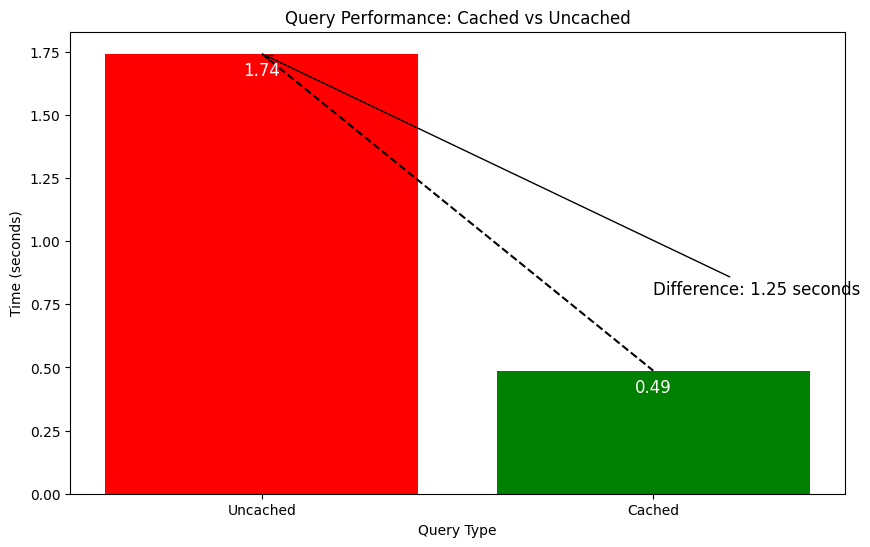

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the chart
times = [1.7415955066680908, 0.48708176612854004]
labels = ['Uncached', 'Cached']

# Calculate the difference
difference = times[0] - times[1]

# Creating the bar chart with annotation
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, times, color=['red', 'green'])
plt.xlabel('Query Type')
plt.ylabel('Time (seconds)')
plt.title('Query Performance: Cached vs Uncached')

# Annotate the bars with the time values
for bar, time in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.1, f'{time:.2f}', ha='center', va='bottom', color='white', fontsize=12)

# Add a line and annotation for the difference
plt.plot(labels, times, linestyle='--', color='black')
plt.annotate(f'Difference: {difference:.2f} seconds', xy=('Uncached', times[0]), xytext=('Cached', times[1] + 0.3),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

plt.show()



In [ ]:
# 10. Partition by the "date_built" field on the formatted parquet home sales data

# Write the data to Parquet format, partitioned by the "date_built" field
df.write.mode("overwrite").partitionBy("date_built").parquet("/content/home_sales_partitioned")

In [ ]:
# 11. Read the parquet formatted data.
# Verify the partitioned Parquet data
partitioned_df = spark.read.parquet("/content/home_sales_partitioned")
partitioned_df.show()

+--------------------+----------+------+--------+---------+-----------+--------+------+----------+----+----------+
|                  id|      date| price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|date_built|
+--------------------+----------+------+--------+---------+-----------+--------+------+----------+----+----------+
|2ed8d509-7372-46d...|2021-08-06|258710|       3|        3|       1918|    9666|     1|         0|  25|      2015|
|941bad30-eb49-4a7...|2020-05-09|229896|       3|        3|       2197|    8641|     1|         0|   3|      2015|
|c797ca12-52cd-4b1...|2019-06-08|288650|       2|        3|       2100|   10419|     2|         0|   7|      2015|
|0cfe57f3-28c2-472...|2019-10-04|308313|       3|        3|       1960|    9453|     2|         0|   2|      2015|
|d715f295-2fbf-4e9...|2021-05-17|391574|       3|        2|       1635|    8040|     2|         0|  10|      2015|
|a18515a2-86f3-46b...|2022-02-18|419543|       3|        2|       1642|   12826|

In [ ]:
# 12. Create a temporary table for the parquet data.

partitioned_df = spark.read.parquet("/content/home_sales_partitioned")

# Create a temporary table from the DataFrame
partitioned_df.createOrReplaceTempView("home_sales_parquet")

# Verify the temporary table by running a query
spark.sql("SELECT * FROM home_sales_parquet LIMIT 10").show()

+--------------------+----------+------+--------+---------+-----------+--------+------+----------+----+----------+
|                  id|      date| price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|date_built|
+--------------------+----------+------+--------+---------+-----------+--------+------+----------+----+----------+
|2ed8d509-7372-46d...|2021-08-06|258710|       3|        3|       1918|    9666|     1|         0|  25|      2015|
|941bad30-eb49-4a7...|2020-05-09|229896|       3|        3|       2197|    8641|     1|         0|   3|      2015|
|c797ca12-52cd-4b1...|2019-06-08|288650|       2|        3|       2100|   10419|     2|         0|   7|      2015|
|0cfe57f3-28c2-472...|2019-10-04|308313|       3|        3|       1960|    9453|     2|         0|   2|      2015|
|d715f295-2fbf-4e9...|2021-05-17|391574|       3|        2|       1635|    8040|     2|         0|  10|      2015|
|a18515a2-86f3-46b...|2022-02-18|419543|       3|        2|       1642|   12826|

In [ ]:
# 13. Using the parquet DataFrame, run the last query above, that calculates
# the average price of a home per "view" rating, rounded to two decimal places,
# having an average home price greater than or equal to $350,000.
# Determine the runtime and compare it to the cached runtime.

# Measure the time for running the query on Parquet data
start_time_parquet = time.time()

# Query to get the average price of a home per "view" rating, rounded to two decimal places, with average price >= $350,000
avg_price_per_view_query = """
SELECT
    view,
    ROUND(AVG(price), 2) as avg_price
FROM
    home_sales_parquet
GROUP BY
    view
HAVING
    avg_price >= 350000
ORDER BY
    view DESC
"""

# Execute the query on Parquet data and show the result
avg_price_per_view_parquet_df = spark.sql(avg_price_per_view_query)
avg_price_per_view_parquet_df.show()

# Time for executing the query on Parquet data
runtime_parquet = time.time() - start_time_parquet
print("--- %s seconds (Parquet) ---" % runtime_parquet)

+----+----------+
|view| avg_price|
+----+----------+
| 100| 1026669.5|
|  99|1061201.42|
|  98|1053739.33|
|  97|1129040.15|
|  96|1017815.92|
|  95| 1054325.6|
|  94| 1033536.2|
|  93|1026006.06|
|  92| 970402.55|
|  91|1137372.73|
|  90|1062654.16|
|  89|1107839.15|
|  88|1031719.35|
|  87| 1072285.2|
|  86|1070444.25|
|  85|1056336.74|
|  84|1117233.13|
|  83|1033965.93|
|  82| 1063498.0|
|  81|1053472.79|
+----+----------+
only showing top 20 rows

--- 1.1565163135528564 seconds (Parquet) ---


In [ ]:
# 14. Uncache the home_sales temporary table.

spark.catalog.uncacheTable("home_sales")

In [ ]:
# 15. Check if the home_sales is no longer cached

is_cached = spark.catalog.isCached("home_sales")
print(f"Is home_sales table cached? {is_cached}")

Is home_sales table cached? False
